In [78]:
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd

<span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">Read and show raw data:

In [44]:
df = pd.read_csv('kinetic_raw.csv')
df

,Time (min),A0,A1,A2,A3,A4,A5,A6
0,0.00,10043.380,0.000,0.000,0.000,0.000,0.000,0.000
1,0.25,4934.811,1222.983,221.920,46.536,60.536,113.364,0.000
2,0.50,3293.933,1933.397,410.941,64.364,90.950,164.192,0.000
3,1.00,1665.397,2432.497,912.548,171.849,127.778,296.263,0.000
4,2.00,441.941,2123.841,1757.841,477.406,244.849,656.941,0.000
5,3.00,135.849,1345.255,2108.598,859.062,513.870,1120.184,79.021
6,4.00,79.192,892.719,1968.719,1056.941,597.991,1499.841,92.435
7,5.00,0.000,408.284,1520.255,1211.355,992.062,2555.497,163.920
8,10.00,0.000,0.000,222.849,608.941,758.598,2464.841,207.577


#### <span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">Normalization (fraction of intermediate):<br>
The following equation was used to normalize data as shown in Figure 1 C : https://doi.org/10.1016/j.cell.2011.05.010
$$ A_i(t) = \frac{A_i(t)}{\sum_{i=0}^{n} A_i(t)} $$

In [46]:
df = pd.concat([df['Time (min)'],df.iloc[:,1:].div(df.iloc[:,1:].sum(axis=1), axis=0)], axis=1)
df

,Time (min),A0,A1,A2,A3,A4,A5,A6
0,0.00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.25,0.747682,0.185296,0.033623,0.007051,0.009172,0.017176,0.000000
2,0.50,0.552880,0.324517,0.068976,0.010803,0.015266,0.027559,0.000000
3,1.00,0.297056,0.433884,0.162771,0.030653,0.022792,0.052844,0.000000
4,2.00,0.077495,0.372419,0.308241,0.083714,0.042935,0.115196,0.000000
5,3.00,0.022047,0.218320,0.342203,0.139416,0.083396,0.181794,0.012824
6,4.00,0.012798,0.144270,0.318159,0.170809,0.096640,0.242385,0.014938
7,5.00,0.000000,0.059592,0.221891,0.176805,0.144798,0.372990,0.023925
8,10.00,0.000000,0.000000,0.052278,0.142850,0.177957,0.578220,0.048695


### <span style="color: #f2cf4a; font-family: monospace; font-size: 1em;">1. Solving for k<sub>1</sub><br>
$$ A_0(t) = e^{-k_1t} $$
$$ -log(A_0(t)) = k_1*t $$

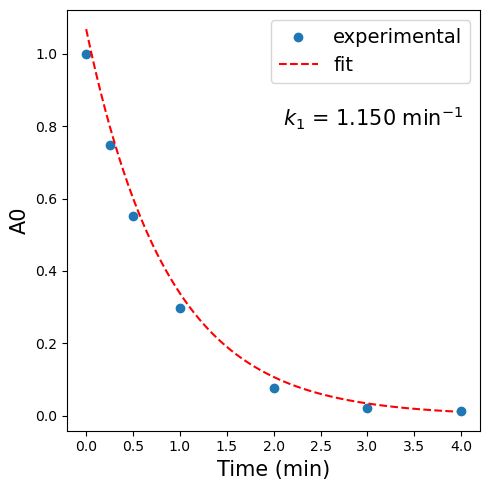

In [99]:
A0 = df['A0'][:-2]  # Read only non-zero A0
t = df['Time (min)'][:-2]

k_1, bias = np.polyfit(t, np.log(1/A0), 1, full=False, cov=False)  # bias = intercept of the fit

# Plot the data points and the fit

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(t, A0, label='experimental')

t_ = np.arange(0, 4, 0.05)
ax.plot(t_, np.exp((-t_ * k_1) + bias), 'r--', label='fit')

ax.text(2.1, 0.8 * np.max(A0), f'$k_1$ = {k_1:.3f} ' r'$\text{min}^{-1}$', fontsize=15, color='black')

ax.set_xlabel('Time (min)', fontsize=15)
ax.set_ylabel('A0', fontsize=15)

ax.legend(fontsize=14)

plt.tight_layout()
plt.show()

In [90]:
# popt, pcov = curve_fit(kinetc_fn, xdata=, ydata=, p0=None) # if known give P0 (initial guesses)

<span style="color: #ffffff; font-family: monospace; font-size: 0.9em;">Build python function mimicing the equation:
$$ A_i(t) = \prod_{j=1}^i k_j \sum_{j=1}^{i+1} \frac{e^{-k_jt}}{\prod_{p=1,p\neq j}^{i+1}(k_p-k_j)} \qquad i=1...n $$

In [ ]:
def kinetc_fn(t, *k):
    '''
    Given rate constants 'k_1' to 'k_n' at time 't',
    returns A_(n-1)
    '''
    n = len(k) # the number of k(parameters) given in
    A = 1.0
    for j in range(1, n):
        x1 = 0.0
        for i in range(1, n+1):
            x0 = np.prod([k[p-1]-k[i-1] for p in range(1, n+1) if p != i])
            x1 += np.exp(-k[i-1]*t/x0)
        A *= k[j-1]*x1   
    return A

### <span style="color: #f2cf4a; font-family: monospace; font-size: 1em;">2. Solving for k<sub>1</sub>, k<sub>2</sub>